Manatees and bombers examples: in both cases damage seen is conditional on survival. We are already looking at a subset of population

In [85]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

In [86]:
rugged = pd.read_csv('./data/rugged.csv', sep=';')

In [87]:
rugged.columns

Index(['isocode', 'isonum', 'country', 'rugged', 'rugged_popw', 'rugged_slope',
       'rugged_lsd', 'rugged_pc', 'land_area', 'lat', 'lon', 'soil', 'desert',
       'tropical', 'dist_coast', 'near_coast', 'gemstones', 'rgdppc_2000',
       'rgdppc_1950_m', 'rgdppc_1975_m', 'rgdppc_2000_m', 'rgdppc_1950_2000_m',
       'q_rule_law', 'cont_africa', 'cont_asia', 'cont_europe', 'cont_oceania',
       'cont_north_america', 'cont_south_america', 'legor_gbr', 'legor_fra',
       'legor_soc', 'legor_deu', 'legor_sca', 'colony_esp', 'colony_gbr',
       'colony_fra', 'colony_prt', 'colony_oeu', 'africa_region_n',
       'africa_region_s', 'africa_region_w', 'africa_region_e',
       'africa_region_c', 'slave_exports', 'dist_slavemkt_atlantic',
       'dist_slavemkt_indian', 'dist_slavemkt_saharan', 'dist_slavemkt_redsea',
       'pop_1400', 'european_descent'],
      dtype='object')

In [88]:
rugged = rugged.dropna(subset = ['rgdppc_2000'])

In [89]:
rugged['log_gdp'] = np.log(rugged.rgdppc_2000) / np.mean(np.log(rugged.rgdppc_2000))

In [90]:
africa = rugged[rugged.cont_africa == 1]
rest_of_world = rugged[rugged.cont_africa == 0]

In [91]:
plt.scatter(africa.log_gdp, africa.standarized_rugged)
plt.scatter(rest_of_world.log_gdp, rest_of_world.standarized_rugged)

AttributeError: 'DataFrame' object has no attribute 'standarized_rugged'

In [92]:
rugged['rugged_scaled'] = rugged.rugged / np.max(rugged.rugged) 
rugged['rugged_standarized'] = rugged.rugged_scaled - np.mean(rugged.rugged_scaled)

In [93]:
with pm.Model() as m1:
    alpha = pm.Normal('alpha', 1, 1)
    beta = pm.Normal('beta', 0, 1)
    mu = pm.Deterministic('mu', alpha + beta * rugged.rugged_standarized)
    sigma = pm.Exponential('sigma',1)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=rugged.log_gdp)

In [94]:
with m1:
    m1_prior = pm.sample_prior_predictive()

<AxesSubplot:>

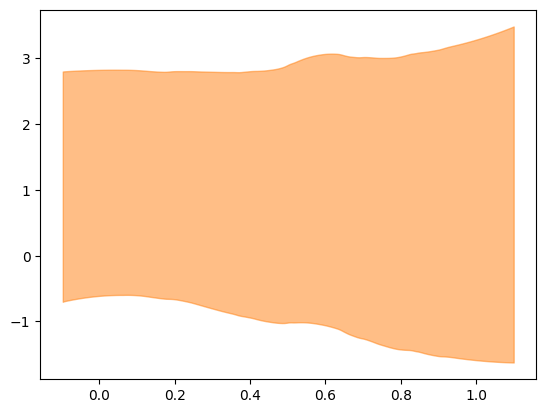

In [95]:
rudgeness_to_plot = np.linspace(-0.1,1.1,100)
az.plot_hdi(rudgeness_to_plot, m1_prior.prior['alpha'].values.T + m1_prior.prior['beta'].values.T * rudgeness_to_plot)

In [96]:
(m1_prior.prior['alpha'].values.T + m1_prior.prior['beta'].values.T * rudgeness_to_plot).shape

(500, 100)

In [97]:
with pm.Model() as m1bis:
    alpha = pm.Normal('alpha', 1, 0.1)
    beta = pm.Normal('beta', 0, 0.3)
    mu = pm.Deterministic('mu', alpha + beta * rugged.rugged_standarized)
    sigma = pm.Exponential('sigma',1)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=rugged.log_gdp)

In [98]:
with m1bis:
    m1bis_prior = pm.sample_prior_predictive()

Text(0.5, 0, 'a')

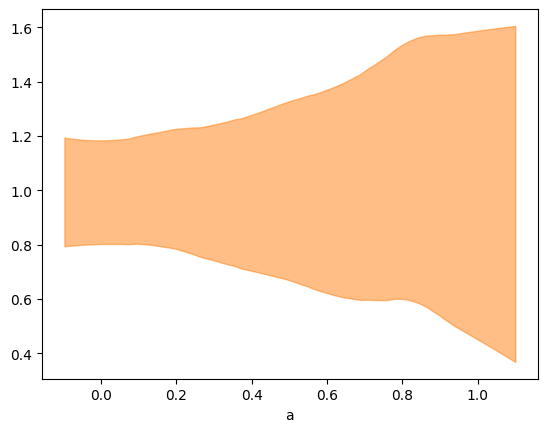

In [99]:
rudgeness_to_plot = np.linspace(-0.1,1.1,100)
az.plot_hdi(rudgeness_to_plot, m1bis_prior.prior['alpha'].values.T + m1bis_prior.prior['beta'].values.T * rudgeness_to_plot)
plt.xlabel("a")



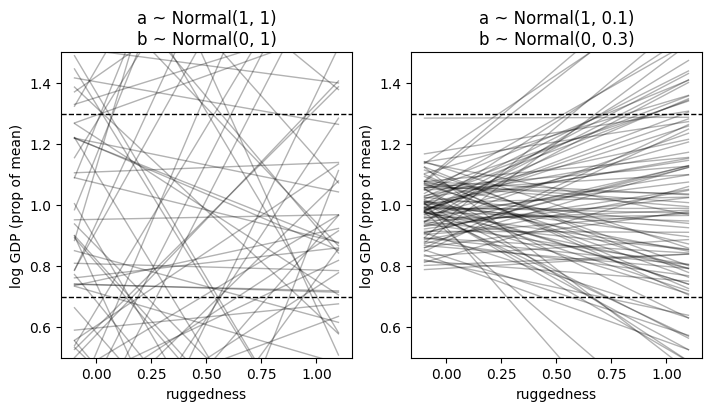

In [104]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=[7, 4], constrained_layout=True)

n = 100
rugged_plot = np.linspace(-0.1, 1.1, n)

# Prior 1
prior = m1_prior.prior.sel(draw=slice(None, None, int(len(m1_prior.prior.draw) / n)))
reglines = prior["alpha"].T.to_numpy() + rugged_plot * prior["beta"].T.to_numpy()
for regline in reglines:
    ax1.plot(
        rugged_plot,
        regline,
        color="k",
        lw=1,
        alpha=0.3,
    )
ax1.set_title("a ~ Normal(1, 1)\nb ~ Normal(0, 1)")

# Prior 2
prior_t = m1bis_prior.prior.sel(draw=slice(None, None, int(len(m1bis_prior.prior.draw) / n)))
reglines_t = prior_t["alpha"].T.to_numpy() + rugged_plot * prior_t["beta"].T.to_numpy()

for regline in reglines_t:
    ax2.plot(
        rugged_plot,
        regline,
        color="k",
        lw=1,
        alpha=0.3,
    )
ax2.set_title("a ~ Normal(1, 0.1)\nb ~ Normal(0, 0.3)")

for ax in (ax1, ax2):
    ax.set_xlabel("ruggedness")
    ax.set_ylabel("log GDP (prop of mean)")
    ax.axhline(0.7, ls="dashed", color="k", lw=1)
    ax.axhline(1.3, ls="dashed", color="k", lw=1)
    ax.set_ylim(0.5, 1.5)

In [105]:
with m1bis:
    m1bis_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [107]:
az.summary(m1bis_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.000,0.010,0.981,1.020,0.000,0.000,5859.0,3134.0,1.0
beta,0.001,0.056,-0.107,0.108,0.001,0.001,6464.0,3118.0,1.0
sigma,0.138,0.008,0.124,0.152,0.000,0.000,5383.0,3086.0,1.0
mu[0],1.000,0.011,0.979,1.020,0.000,0.000,5898.0,3447.0,1.0
mu[1],1.000,0.022,0.961,1.045,0.000,0.000,6024.0,3098.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[165],1.000,0.011,0.980,1.021,0.000,0.000,5765.0,3214.0,1.0
mu[166],1.000,0.014,0.975,1.029,0.000,0.000,5780.0,3023.0,1.0
mu[167],1.000,0.011,0.980,1.022,0.000,0.000,5744.0,3128.0,1.0
mu[168],1.000,0.012,0.976,1.022,0.000,0.000,5995.0,3636.0,1.0


In [110]:
with pm.Model() as m2:
    alphas = [pm.Normal('alpha_africa', 1, 0.1), pm.Normal('alpha_nonafrica', 1, 0.2)]
    beta = pm.Normal('beta', 0, 0.3)
    alpha = alphas[0] * rugged.cont_africa + alphas[1] * (1-rugged.cont_africa)
    mu = pm.Deterministic('mu', alpha + beta * rugged.rugged_standarized)
    sigma = pm.Exponential('sigma',1)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=rugged.log_gdp)

In [111]:
with m2:
    m2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_africa, alpha_nonafrica, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [115]:
az.compare({'m1':m1bis_trace, 'm2':m2_trace})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m2,0,126.195308,4.092346,0.00000,0.968645,7.407369,0.000000,False,log
m1,1,94.438598,2.564519,31.75671,0.031355,6.472848,7.349211,False,log


In [116]:
az.summary(m2_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_africa,0.880,0.016,0.849,0.909,0.000,0.000,6731.0,3197.0,1.0
alpha_nonafrica,1.050,0.011,1.030,1.069,0.000,0.000,6612.0,2992.0,1.0
beta,-0.046,0.046,-0.134,0.037,0.001,0.001,6240.0,2780.0,1.0
sigma,0.114,0.006,0.103,0.126,0.000,0.000,5819.0,3305.0,1.0
mu[0],0.884,0.016,0.853,0.913,0.000,0.000,7260.0,2915.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[165],1.047,0.011,1.028,1.068,0.000,0.000,6781.0,3383.0,1.0
mu[166],1.042,0.012,1.019,1.065,0.000,0.000,7040.0,3294.0,1.0
mu[167],0.877,0.016,0.846,0.907,0.000,0.000,6337.0,3252.0,1.0
mu[168],0.886,0.016,0.856,0.917,0.000,0.000,7350.0,2906.0,1.0


Text(0.5, 1.0, 'Contrast between intercepts for Africa and Non Africa')

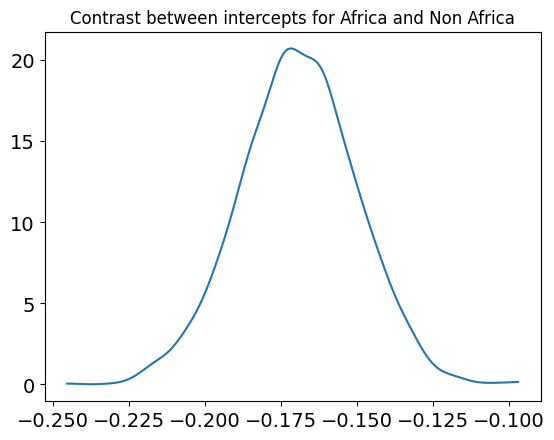

In [125]:
az.plot_kde(m2_trace.posterior['alpha_africa'].to_numpy() - m2_trace.posterior['alpha_nonafrica'].to_numpy())
plt.title('Contrast between intercepts for Africa and Non Africa')

This means that given a country with average rudgeness, if the country
is African it will have lower GDP.

So just adding the African alpha parameter allows for a little better
prediction just because of the average behavior, only one slope, so there's little
descriptive power just yet.

In [126]:
with pm.Model() as m3:
    alphas = [pm.Normal('alpha_africa', 1, 0.1), pm.Normal('alpha_nonafrica', 1, 0.2)]
    betas = [pm.Normal('beta_africa', 0, 0.3), pm.Normal('beta_nonafrica', 0, 0.3)]
    alpha = alphas[0] * rugged.cont_africa + alphas[1] * (1-rugged.cont_africa)
    beta = betas[0] * rugged.cont_africa + betas[1] * (1-rugged.cont_africa)
    mu = pm.Deterministic('mu', alpha + beta * rugged.rugged_standarized)
    sigma = pm.Exponential('sigma',1)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=rugged.log_gdp)

In [127]:
with m3:
    m3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_africa, alpha_nonafrica, beta_africa, beta_nonafrica, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [128]:
az.compare({'m1':m1bis_trace, 'm2':m2_trace,
           'm3':m3_trace})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m3,0,129.727836,4.850946,0.000000,0.874558,7.304150,0.000000,False,log
m2,1,126.195308,4.092346,3.532528,0.125442,7.407369,3.251605,False,log
m1,2,94.438598,2.564519,35.289237,0.000000,6.472848,7.443459,False,log


In [ ]:
So the interaction adds predictive power. The dse between m3 and m1 is as big as the difference.

In [129]:
az.summary(m3_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_africa,0.887,0.016,0.856,0.916,0.000,0.000,6417.0,3221.0,1.0
alpha_nonafrica,1.051,0.010,1.030,1.068,0.000,0.000,5527.0,3507.0,1.0
beta_africa,0.133,0.075,-0.007,0.272,0.001,0.001,5990.0,3366.0,1.0
beta_nonafrica,-0.143,0.055,-0.239,-0.037,0.001,0.001,6013.0,3581.0,1.0
sigma,0.112,0.006,0.100,0.124,0.000,0.000,6289.0,3576.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[165],1.043,0.010,1.024,1.062,0.000,0.000,5787.0,3375.0,1.0
mu[166],1.028,0.013,1.004,1.053,0.000,0.000,6109.0,3333.0,1.0
mu[167],0.896,0.018,0.864,0.930,0.000,0.000,5874.0,3154.0,1.0
mu[168],0.870,0.017,0.838,0.903,0.000,0.000,7512.0,3473.0,1.0


NameError: name 'm_8_3_posterior' is not defined

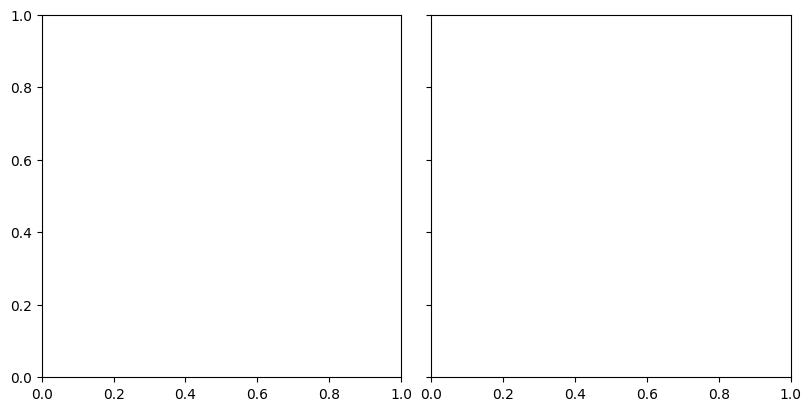

In [131]:
_, axs = plt.subplots(
    1,
    2,
    figsize=[8, 4],
    sharey=True,
    constrained_layout=True,
)

ax1, ax0 = axs

# extract posterior samples of parameters
posterior = m3_trace.posterior
a0 = posterior["alpha"][0, :].to_numpy()
a1 = posterior["alpha"][1, :].to_numpy()
b0 = posterior["beta"][0, :].to_numpy()
b1 = posterior["beta"][1, :].to_numpy()

rugged_plot = np.linspace(-0.1, 1.1)

ax0.scatter(
    dd.loc[cid == 0, "rugged_std"],
    dd.loc[cid == F0, "log_gdp_std"],
    label="Not Africa",
    facecolor="w",
    lw=1,
    edgecolor="k",
)
# calculating predicted manually because this is a pain with categorical variabiles in PyMC
pred0 = a0 + rugged_plot.reshape(-1, 1) * b0
ax0.plot(rugged_plot, pred0.mean(1), color="grey")
az.plot_hdi(rugged_plot, pred0.T, color="grey", hdi_prob=0.97, ax=ax0)
ax0.set_title("Non-African Nations")

ax1.scatter(
    dd.loc[cid == 1, "rugged_std"],
    dd.loc[cid == 1, "log_gdp_std"],
    label="Africa",
    color="b",
)
# calculating predicted manually because this is a pain with categorical variabiles in PyMC
pred1 = a1 + rugged_plot.reshape(-1, 1) * b1
ax1.plot(rugged_plot, pred1.mean(1), color="k")
az.plot_hdi(
    rugged_plot,
    pred1.T,
    color="blue",
    hdi_prob=0.97,
    ax=ax1,
    fill_kwargs={"alpha": 0.2},
)
ax1.set_title("African Nations")


ax.set_xlim(-0.1, 1.1)
ax0.set_xlabel("ruggedness (standardised)")
ax1.set_xlabel("ruggedness (standardised)")
ax0.set_ylabel("")


In [133]:
tulips = pd.read_csv('./data/tulips.csv', sep=';')

In [137]:
water = tulips.water - tulips.water.mean()
shade = tulips.shade - tulips.shade.mean()
blooms = tulips.blooms - tulips.blooms.max()

In [140]:
with pm.Model() as tulips1:
    beta_water = pm.Normal('beta_water',0,0.25)
    beta_shade = pm.Normal('beta_shade',0,0.25)
    alpha = pm.Normal('alpha',0.5,0.25)
    sigma = pm.Exponential('sigma',1)
    mu = pm.Deterministic('mu', alpha+beta_shade * shade + beta_water * water)
    y = pm.Normal('y',mu, sigma, observed=blooms)

In [144]:
with pm.Model() as tulips2:
    beta_water = pm.Normal('beta_water',0,0.25)
    beta_shade = pm.Normal('beta_shade',0,0.25)
    beta_interaction = pm.Normal('beta_interaction',0,0.25)
    """
    The motivation to choose this prior is that
    we believe that a lot of shade makes water have an oposite effect, but proportional, so we set the same
    sd as beta_shared
    """
    alpha = pm.Normal('alpha',0.5,0.25)
    sigma = pm.Exponential('sigma',1)
    mu = pm.Deterministic('mu', alpha+beta_shade * shade + beta_water * water + beta_interaction * water * shade)
    y = pm.Normal('y',mu, sigma, observed=blooms)

In [145]:
with tulips1:
    tulips1_prior = pm.sample_prior_predictive()
    tulips1_posterior = pm.sample()
with tulips2:
    tulips2_prior = pm.sample_prior_predictive()
    tulips2_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_water, beta_shade, beta_interaction, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_water, beta_shade, beta_interaction, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [147]:
_, axs = plt.subplots(2, 3, figsize=[9, 5], sharey=True, sharex=True, constrained_layout=True)
n_lines = 20
pred_x = np.array([-1, 1])

for i, shade in enumerate([-1, 0, 1]):
    ind = d.shade_cent == shade
    for ax in axs[:, i]:
        ax.scatter(blooms.loc[ind, "water_cent"], d.loc[ind, "blooms_std"])
     # top row, m_8_4
     ax = axs[0, i]
     ax.set_title(f"m8.4 post: shade = {shade:.0f}", fontsize=11)
     pred_y = (
         m_8_4_post["a"][:n_lines].to_numpy()
         + m_8_4_post["bw"][:n_lines].to_numpy() * pred_x.reshape(-1, 1)
         + m_8_4_post["bs"][:n_lines].to_numpy() * shade
     )
     ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))


<xarray.Dataset>
Dimensions:           (chain: 4, draw: 1000, mu_dim_0: 27)
Coordinates:
  * chain             (chain) int64 0 1 2 3
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * mu_dim_0          (mu_dim_0) int64 0 1 2 3 4 5 6 7 ... 20 21 22 23 24 25 26
Data variables:
    beta_water        (chain, draw) float64 0.1828 -0.2361 ... 0.05864 0.315
    beta_shade        (chain, draw) float64 -0.2383 0.2289 ... 0.2646 -0.03908
    beta_interaction  (chain, draw) float64 -0.1202 0.1199 ... -0.122 0.1972
    alpha             (chain, draw) float64 0.6228 0.3237 ... 0.4405 0.2692
    sigma             (chain, draw) float64 113.9 108.4 114.7 ... 111.6 99.94
    mu                (chain, draw, mu_dim_0) float64 0.5581 0.44 ... 0.7422
Attributes:
    created_at:                 2023-07-12T18:38:43.603748
    arviz_version:              0.12.1
    inference_library:          pymc
    inference_library_version:  4.1.4
    sampling_time:              21.504027843475342
    tuning_steps:               1000